In [20]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

# 生成数据集

⽣成⼀个包含1000个样本的数据集，每个样本包含从标准正态分布中采样的2个特征。我们的合成数据集是⼀个矩阵X ∈ R^1000×2。  
使⽤线性模型参数w = [2, −3.4]⊤、b = 4.2 和噪声项ϵ⽣成数据集及其标签：  
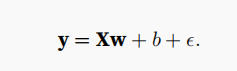  
ϵ可以视为模型预测和标签时的潜在观测误差。ϵ服从均值为0的正态分布。

In [21]:
def synthetic_data(w, b, num_examples): #@save
    """⽣成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [22]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [23]:
#features中的每⼀⾏都包含⼀个⼆维数据样本，labels中的每⼀⾏都包含⼀维标签值（⼀个标量）
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([0.1345, 1.0365]) 
label: tensor([0.9312])


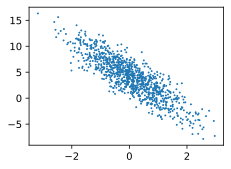

In [24]:
#可视化
#通过⽣成第⼆个特征features[:, 1]和labels的散点图，可以直观观察到两者之间的线性关系
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);

# 读取数据集

定义⼀个data_iter函数，该函数接收批量⼤⼩、特征矩阵和标签向量作为输⼊，⽣成⼤⼩为batch_size的⼩批量。每个⼩批量包含⼀组特征和标签。

In [25]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [26]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 2.1370, -0.1089],
        [-0.6817,  0.2026],
        [-0.1138, -0.6531],
        [ 0.6385,  0.4571],
        [ 1.2452, -1.3805],
        [ 0.0229,  1.0148],
        [-0.2464,  0.1519],
        [-0.8222,  0.2514],
        [ 0.8408, -0.3891],
        [-0.1844,  0.0198]]) 
 tensor([[ 8.8395],
        [ 2.1346],
        [ 6.1787],
        [ 3.9170],
        [11.3886],
        [ 0.8081],
        [ 3.1919],
        [ 1.6947],
        [ 7.2016],
        [ 3.7429]])


# 初始化模型参数

⼩批量随机梯度下降优化模型参数之前，需要先有⼀些参数，通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重w，并将偏置b初始化为0。

In [27]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

## 定义模型

In [28]:
def linreg(X, w, b): #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

## 定义损失函数

In [29]:
def squared_loss(y_hat, y): #@save
    """均⽅损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## 定义优化算法

⼩批量随机梯度下降：在每⼀步中，使⽤从数据集中随机抽取的⼀个⼩批量，然后根据参数计算损失的梯度。接下来，朝着减少损失的⽅向更新我们的参数。下⾯的函数实现⼩批量随机梯度下降更新。该函数接受模型参数集合、学习速率和
批量⼤⼩作为输⼊。每⼀步更新的⼤⼩由学习速率lr决定。因为我们计算的损失是⼀个批量样本的总和，所以我们⽤批量⼤⼩（batch_size）来规范化步⻓，这样步⻓⼤⼩就不会取决于我们对批量⼤⼩的选择。

In [30]:
def sgd(params, lr, batch_size): #@save
    """⼩批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()


## 训练
在每次迭代中，我们读取⼀⼩批量训练样本，并通过我们的模型来获得⼀组预测。计算完损失后，我们开始反向传播，存储每个参数的梯度。最后，我们调⽤优化算法sgd来更新模型参数。  
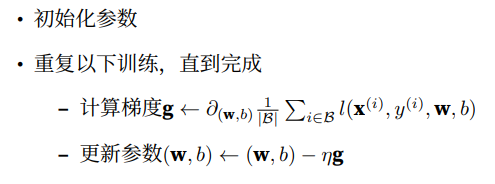

在每个迭代周期（epoch）中，我们使⽤data_iter函数遍历整个数据集，并将训练数据集中所有样本都使⽤⼀次（假设样本数能够被批量⼤⼩整除）。这⾥的迭代周期个数num_epochs和学习率lr都是超参数，分别设为3和0.03。设置超参数很棘⼿，需要通过反复试验进⾏调整。

In [31]:
lr = 0.03
num_epochs = 10
net = linreg
loss = squared_loss

In [32]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # X和y的⼩批量损失
        # 因为l形状是(batch_size,1)，⽽不是⼀个标量。l中的所有元素被加到⼀起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size) # 使⽤参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')


epoch 1, loss 0.051325
epoch 2, loss 0.000227
epoch 3, loss 0.000054
epoch 4, loss 0.000054
epoch 5, loss 0.000054
epoch 6, loss 0.000053
epoch 7, loss 0.000054
epoch 8, loss 0.000054
epoch 9, loss 0.000053
epoch 10, loss 0.000054


In [34]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')


w的估计误差: tensor([5.4836e-05, 8.9741e-04], grad_fn=<SubBackward0>)
b的估计误差: tensor([-4.3392e-05], grad_fn=<RsubBackward1>)
